# Evaluate SAM1/SAM2

## ade20k sam1 sam2 comparison

In [1]:
#Code to evaluate SAM2 with 64 images from ade20k
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
from source.sam import evaluate_sam, sam12_info
from source.eval_and_plotting import (SavedSamples, DiffSamples, SavedSamplesManager)
import matplotlib.pyplot as plt
from source.utils.mixed_utils import shaprint
import argparse
import numpy as np
import glob
import tqdm

# this prevents a weird bug with matplotlib
plt.imshow(np.random.rand(10,10))
plt.close()

### plotting 64

In [2]:
name = sam12_info["names"][0]
save_path = f"saves/sam_eval/sam12_comp/{name}_64_ade20k.pt"
sam_samples = SavedSamples()
sam_samples.load(save_path)
ssm = SavedSamplesManager(sam_samples)

(384, 603, 3)
(768, 1206, 3)
{'left': ['   Raw\n Image  ', '   Ground\n Truth  ', '   sam1_b  '], 'top': ['ade20k/27427', 'ade20k/26351', 'ade20k/27410', 'ade20k/26040'], 'xtick_kwargs': {'fontsize': 20}}


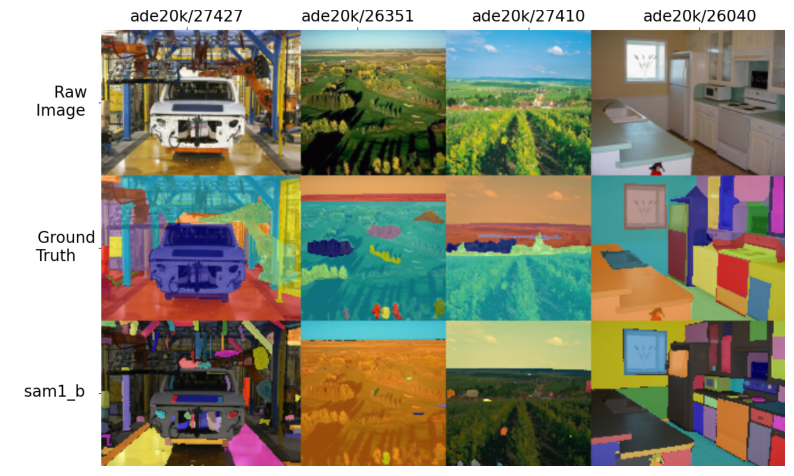

In [40]:
im = ssm.plot_qual_seg(transpose=True,add_text_axis=True,add_text_inside=True,pixel_mult=2)

fig = plt.figure(figsize=(10,10))
plt.imshow(im)
plt.axis("off");

## plotting 256

In [2]:
save_folder = f"saves/sam_eval/sam12_comp/"
ssm = SavedSamplesManager()
for save_path in glob.glob(f"{save_folder}/*"):
    if "256" in save_path:
        sam_samples = SavedSamples()
        sam_samples.load(save_path)
        print("Loaded",save_path)
        ssm.add_saved_samples(sam_samples)
ssm.sort_saved_samples(key=lambda x: sam12_info["names"].index(x.name))

Loaded saves/sam_eval/sam12_comp/sam1_b_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam2_s_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam1_l_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam2_l_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam2_b+_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam1_h_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam2_t_256_ade20k.pt


In [5]:
ssm.mean_metric_table()

,sam1_b,sam1_l,sam1_h,sam2_t,sam2_s,sam2_b+,sam2_l
ari,0.362,0.537,0.544,0.27,0.315,0.375,0.407
hiou,0.156,0.135,0.132,0.188,0.21,0.217,0.265
iou,0.011,0.012,0.0103,0.0171,0.0259,0.0306,0.0295
mi,0.523,0.66,0.664,0.423,0.466,0.524,0.563


(445, 1152, 3)
(890, 2304, 3)
{'top': ['Raw\n Image', 'Ground\n Truth', 'sam1_b', 'sam1_l', 'sam1_h', 'sam2_t', 'sam2_s', 'sam2_b+', 'sam2_l'], 'left': ['   ade20k/27427  ', '   ade20k/26351  ', '   ade20k/27410  ', '   ade20k/26040  '], 'xtick_kwargs': {'fontsize': 20}}


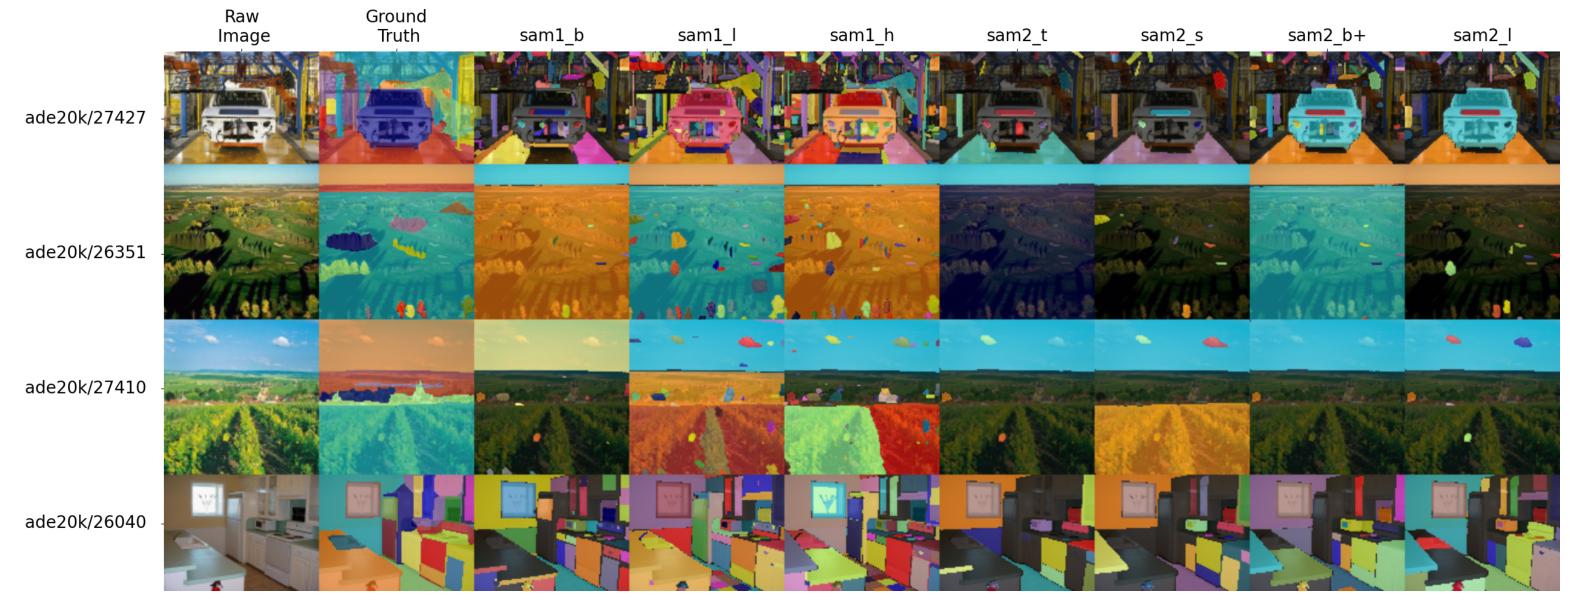

In [9]:
im = ssm.plot_qual_seg(transpose=False,add_text_axis=True,add_text_inside=False,pixel_mult=2)

fig = plt.figure(figsize=(20,20))
plt.imshow(im)
plt.axis("off");

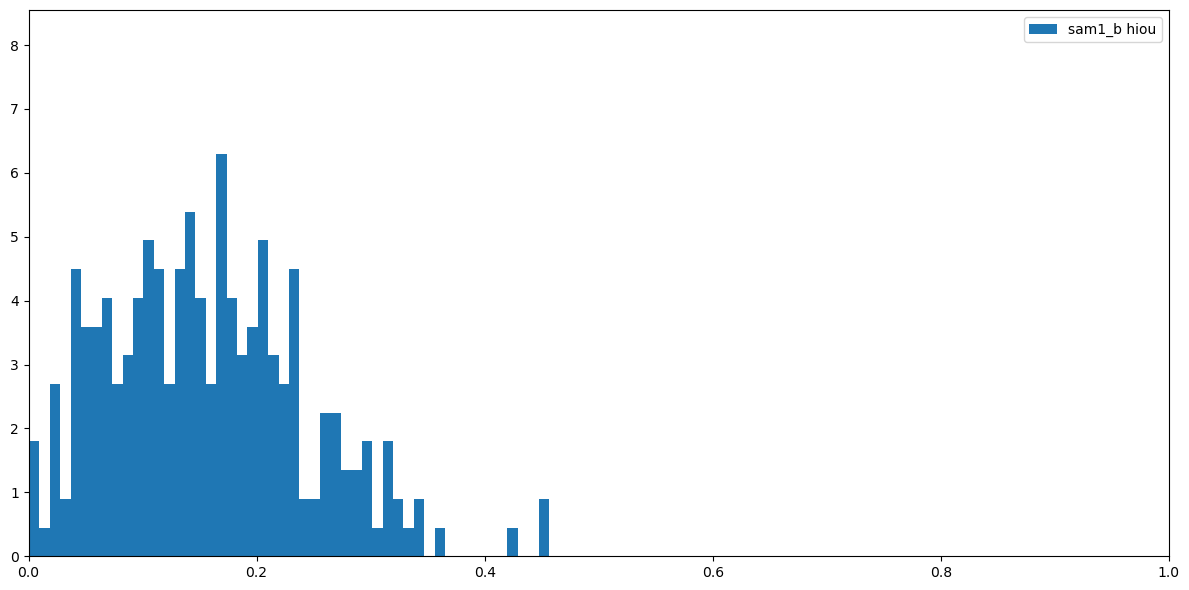

In [22]:
ssm.hist(ss_idx=[0],metric_names="hiou",bins=50)

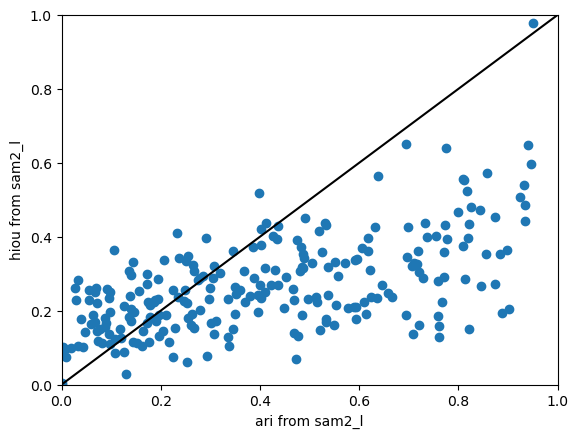

In [17]:
ssm.scatter(metric1="ari",metric2="hiou",ss_idx1=6)

## postprocessing for sam2_l

In [38]:
save_path = f"saves/sam_eval/sam12_comp/sam2_l_256_ade20k.pt"

sam_samples = SavedSamples()
sam_samples.load(save_path)
didx_w_heavy = []
for k,v in sam_samples.heavy_available.items():
    if v=="pos_loaded":
        didx_w_heavy.append(k)
print("Didx with heavy",len(didx_w_heavy))

sam_samples = sam_samples.reduce_by_indexer(didx_w_heavy)
print(len(sam_samples))

Didx with heavy 63
63


In [39]:

ssm = SavedSamplesManager(sam_samples)
min_areas = np.logspace(np.log10(0.001),np.log10(0.15),10)
for min_area in tqdm.tqdm(min_areas):
    sam_samples2 = sam_samples.clone(f"area>={min_area:.4f}")
    sam_samples2.postprocess({"mode": "min_area", "min_area": min_area})
    sam_samples2.clear_heavy_data()
    ssm.add_saved_samples(sam_samples2)
    

100%|██████████| 10/10 [08:16<00:00, 49.63s/it]


In [40]:
ssm.mean_metric_table()


,sam2_l,area>=0.0010,area>=0.0017,area>=0.0030,area>=0.0053,area>=0.0093,area>=0.0162,area>=0.0282,area>=0.0493,area>=0.0860,area>=0.1500
ari,0.398,0.402,0.402,0.401,0.399,0.394,0.375,0.344,0.318,0.272,0.183
hiou,0.264,0.281,0.282,0.283,0.268,0.24,0.185,0.135,0.109,0.0852,0.0565
iou,0.0364,0.0382,0.0385,0.0387,0.0395,0.0394,0.0387,0.0372,0.0337,0.0312,0.0203
mi,0.547,0.557,0.557,0.555,0.55,0.54,0.51,0.463,0.423,0.36,0.253


In [41]:
mean_metrics = ssm.mean_metric_table(to_df=False)
print(mean_metrics)

{'sam2_l': {'ari': '0.398', 'hiou': '0.264', 'iou': '0.036', 'mi': '0.547'}, 'area>=0.0010': {'ari': '0.402', 'hiou': '0.281', 'iou': '0.038', 'mi': '0.557'}, 'area>=0.0017': {'ari': '0.402', 'hiou': '0.282', 'iou': '0.038', 'mi': '0.557'}, 'area>=0.0030': {'ari': '0.401', 'hiou': '0.283', 'iou': '0.039', 'mi': '0.555'}, 'area>=0.0053': {'ari': '0.399', 'hiou': '0.268', 'iou': '0.040', 'mi': '0.550'}, 'area>=0.0093': {'ari': '0.394', 'hiou': '0.240', 'iou': '0.039', 'mi': '0.540'}, 'area>=0.0162': {'ari': '0.375', 'hiou': '0.185', 'iou': '0.039', 'mi': '0.510'}, 'area>=0.0282': {'ari': '0.344', 'hiou': '0.135', 'iou': '0.037', 'mi': '0.463'}, 'area>=0.0493': {'ari': '0.318', 'hiou': '0.109', 'iou': '0.034', 'mi': '0.423'}, 'area>=0.0860': {'ari': '0.272', 'hiou': '0.085', 'iou': '0.031', 'mi': '0.360'}, 'area>=0.1500': {'ari': '0.183', 'hiou': '0.056', 'iou': '0.020', 'mi': '0.253'}}


In [63]:
refv

'0.547'

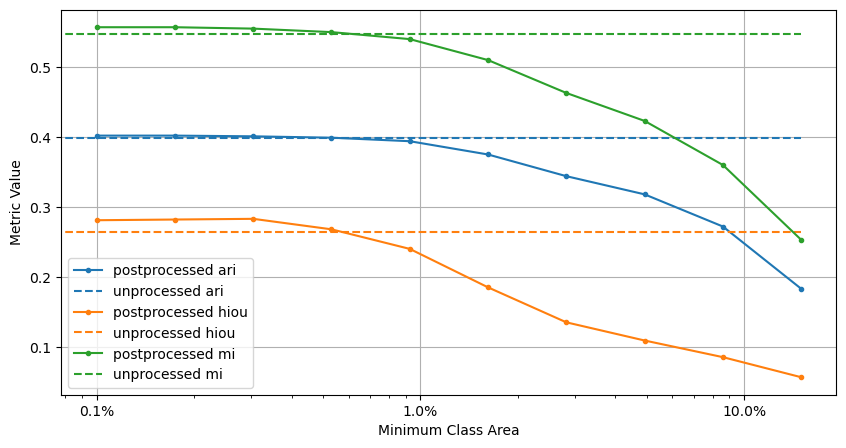

In [71]:
mean_metrics = ssm.mean_metric_table(to_df=True)
metric_keys = ["ari","hiou","mi"]
ref_col = "sam2_l"
plt.figure(figsize=(10,5))
for k,m in enumerate(metric_keys):
    vals = [float(x) for x in mean_metrics.loc[m]]
    plt.plot(min_areas,vals[1:],".-",label=f"postprocessed {m}",color=f"C{k}")
    refv = mean_metrics.loc[m][ref_col]
    plt.plot([0,max(min_areas)], [vals[0],vals[0]],"--",label=f"unprocessed {m}",color=f"C{k}")
plt.grid()
plt.xlabel("Minimum Class Area")
plt.xscale("log")
plt.ylabel("Metric Value")
plt.legend()

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))

## scatter of sam1 and sam2

python train.py --model_name g25+slow+128
python train.py --model_name g25+slow
f